# Measuring Synaptic Kinetics

In this notebook we use the [Allen Institute synaptic physiology dataset](https://portal.brain-map.org/explore/connectivity/synaptic-physiology) to measure the kinetic properties of synaptic connections and the relationship to cell subclass.

For an introduction to the Jupyter Notebook interface interface, try [Codeacademy: How To Use Jupyter Notebooks]( https://www.codecademy.com/articles/how-to-use-jupyter-notebooks) or [Jupyter Notebook Quick Start Guide](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html).


In [1]:
import numpy as np
from aisynphys.database import SynphysDatabase
from aisynphys.cell_class import CellClass

In [2]:
# Download and cache the sqlite file for the requested database
#   (for available versions, see SynphysDatabase.list_versions)
db = SynphysDatabase.load_current('small')

We are going to compare the strength of excitatory connectivity onto the three inhibitory cell subclassess -- Pvalb, Sst, and Vip.

Begin by defining these subclasses:

In [3]:
post_classes = {
    'pvalb': CellClass(cre_type='pvalb'),
    'sst': CellClass(cre_type='sst'),
    'vip': CellClass(cre_type='vip'),
}

Query the database to get all excitatory synapses with a specific postsynaptic cre type. We also filter here for "standard multipatch" experiment types in order to exclude other experiment types as well as filter for "mouse" as the species.

In [4]:
# query once for each postsynaptic type, building up a Pandas dataframe

pairs = None
for name, post_class in post_classes.items():
    pair_query = db.pair_query(
        experiment_type='standard multipatch',
        species='mouse',
        post_class=post_class,
        synapse=True,
        synapse_type='ex',
    )
    pair_query = pair_query.add_columns(
        db.Synapse.latency,
        db.Synapse.psc_rise_time,
        db.Synapse.psc_decay_tau,
        db.Synapse.psp_amplitude,
    )
    df = pair_query.dataframe()
    df['post_class'] = name
    if pairs is None:
        pairs = df
    else:
        pairs = pairs.append(df)
    print("%s: %d synapses" % (name, len(df)))

pvalb: 144 synapses
sst: 118 synapses
vip: 30 synapses


/home/luke/docs/aisynphys/aisynphys/database/database.py:758: SAWarning: TypeDecorator FloatType() will not produce a cache key because the ``cache_ok`` flag is not set to True.  Set this flag to True if this type object's state is safe to use in a cache key, or False to disable this warning.
  recs = self.all()


In [5]:
# we now have all synapses loaded into one dataframe:
pairs.head()

,pair.id,pair.experiment_id,pair.pre_cell_id,pair.post_cell_id,pair.has_synapse,pair.has_polysynapse,pair.has_electrical,pair.crosstalk_artifact,pair.n_ex_test_spikes,pair.n_in_test_spikes,pair.distance,pair.lateral_distance,pair.vertical_distance,pair.reciprocal_id,pair.meta,synapse.latency,synapse.psc_rise_time,synapse.psc_decay_tau,synapse.psp_amplitude,post_class
0,16618,355,2534,2524,True,False,False,NaN,60,60,0.000071,NaN,NaN,16574,None,NaN,NaN,NaN,NaN,pvalb
1,13143,274,1981,1978,True,False,False,NaN,936,720,0.000076,0.000004,0.000019,13093,None,0.001243,0.001220,0.002434,0.000540,pvalb
2,58864,1723,10233,10220,True,False,False,NaN,384,72,0.000049,0.000004,0.000038,58700,None,0.000862,NaN,NaN,0.001326,pvalb
3,13103,274,1979,1978,True,False,False,NaN,531,443,0.000067,0.000049,0.000011,13090,None,0.001322,0.000901,0.004337,NaN,pvalb
4,22127,480,3384,3378,True,False,False,NaN,690,690,0.000139,0.000090,0.000072,22011,None,0.000836,NaN,NaN,0.000122,pvalb


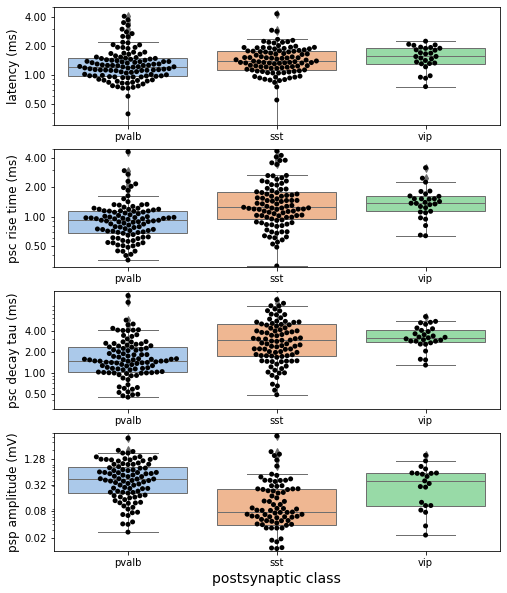

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

limits = {
    'latency': (0.3e-3, 5e-3),
    'psc_rise_time': (0.3e-3, 5e-3),
    'psc_decay_tau': (0.3e-3, 15e-3),
    'psp_amplitude': (10e-6, 5e-3),
}
units = ['ms', 'ms', 'ms', 'mV']
ticks = {
    'ms': 0.5e-3 * 2**np.arange(4),
    'mV': 20e-6 * 4**np.arange(4),
}

fig,ax = plt.subplots(len(limits), 1, figsize=(8, 2.5 * len(limits)))


for i, (field, lim) in enumerate(limits.items()):
    # box and swarm plots
    ax[i].set_yscale('log')
    ax[i].set_ylim(*lim)
    sns.boxplot(x="post_class", y="synapse."+field, data=pairs, ax=ax[i], palette='pastel', width=0.8, linewidth=1)
    sns.swarmplot(x="post_class", y="synapse."+field, data=pairs, ax=ax[i], size=5, color=(0, 0, 0, 0.5))
    
    # clean up labels / ticks
    if i == len(limits)-1:
        ax[i].set_xlabel('postsynaptic class', size=14)
    else:
        ax[i].set_xlabel('')
    ax[i].set_ylabel(field.replace('_', ' ') + ' (%s)'%units[i], size=12)
    ax[i].set_yticks(ticks[units[i]])
    ax[i].set_yticklabels(['%0.2f' % (x*1000) for x in ticks[units[i]]])
    ax[i].set_yticklabels([], minor=True)


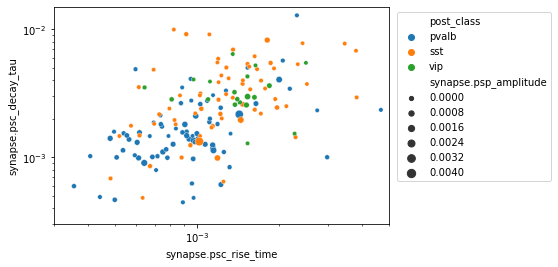

In [7]:
fig,ax = plt.subplots()

x_field = 'psc_rise_time'
y_field = 'psc_decay_tau'
ax.set_xlim(limits[x_field])
ax.set_ylim(limits[y_field])
ax.set_yscale('log')
ax.set_xscale('log')

sns.scatterplot(
    x="synapse."+x_field, 
    y="synapse."+y_field, 
    hue="post_class", 
    size="synapse.psp_amplitude", 
    data=pairs, 
    ax=ax,
)
ax.legend(loc="upper right", bbox_to_anchor=(1.5, 1))